# Run experiments

In [1]:
from audiointerp.dataset.esc50 import ESC50dataset, ESC50contaminated
from audiointerp.model.cnn14 import TransferCnn14
from audiointerp.fit import Trainer
from audiointerp.processing.spectrogram import LogMelSTFTSpectrogram
from audiointerp.interpretation.saliency import SaliencyInterpreter
from audiointerp.interpretation.gradcam import GradCAMInterpreter
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as T_audio
import torchvision.transforms as T_vision
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np
from IPython.display import Audio
from audiointerp.predict import Predict
from audiointerp.metrics import Metrics

/home/yuliya/coursework24/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_learning_curves(train_losses, val_losses, train_accs=None, val_accs=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    if val_losses:
        plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    if train_accs is not None:
        plt.plot(epochs, train_accs, label="Train Acc")
    if val_accs is not None:
        plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [3]:
root_dir = "/home/yuliya/ESC50"
sr = 32000
train_folds = [1, 2, 3]
valid_folds = [4]
test_folds = [5]

In [4]:
n_fft = 1024
hop_length = 320
win_length = 1024
n_mels = 64
f_min = 50
f_max = 14000
top_db = 80

In [5]:
feature_extractor_fit = LogMelSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    sample_rate=sr, n_mels=n_mels, f_min=f_min, f_max=f_max, top_db=top_db,
    return_phase=False, return_full_db=False
)

In [6]:
feature_extractor_predict = LogMelSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    sample_rate=sr, n_mels=n_mels, f_min=f_min, f_max=f_max, top_db=top_db,
    return_phase=True, return_full_db=True
)

In [7]:
feature_augs = nn.Sequential(
    T_audio.FrequencyMasking(20),
    T_audio.TimeMasking(20)
)

In [8]:
train_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=train_folds, normalize="peak", feature_extractor=feature_extractor_fit, feature_augs=feature_augs)
valid_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=valid_folds, normalize="peak", feature_extractor=feature_extractor_fit)
test_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=test_folds, normalize="peak", feature_extractor=feature_extractor_fit)
test_data_noisy = ESC50contaminated(root_dir=root_dir, sr=sr, folds=test_folds, normalize="peak", feature_extractor=feature_extractor_fit,
                                    path_to_contaminating_audio="samples/sea_waves.wav")

In [9]:
train_loader_kwargs = {"batch_size": 32, "shuffle": True}
valid_loader_kwargs = {"batch_size": 32, "shuffle": False}
test_loader_kwargs = {"batch_size": 32, "shuffle": False}

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cls = TransferCnn14
model_kwargs = {"num_classes": 50, "num_bins": 64}
model_pretrain_weights_path = "weights/Cnn14_mAP=0.431.pth"

optimizer_cls = optim.Adam
optimizer_kwargs = {"lr": 1e-4}

criterion_cls = nn.CrossEntropyLoss
use_mixup = True
mixup_alpha = 0.2

In [11]:
model_trainer = Trainer(
    model_cls=model_cls,
    train_data=train_data,
    train_loader_kwargs=train_loader_kwargs,
    criterion_cls=criterion_cls,
    optimizer_cls=optimizer_cls,
    model_kwargs=model_kwargs,
    model_pretrain_weights_path=model_pretrain_weights_path,
    optimizer_kwargs=optimizer_kwargs,
    device=device,
    valid_data=valid_data,
    valid_loader_kwargs=valid_loader_kwargs,
    test_data=test_data,
    test_loader_kwargs=test_loader_kwargs,
    use_mixup=use_mixup,
    mixup_alpha=mixup_alpha
)

Random seed set to: 42


In [25]:
train_losses, train_accs, val_losses, val_accs, test_loss, test_acc = model_trainer.train(num_epochs=20, save_weights_path="logmel_cnn14.pth")

Epoch:   5%|▌         | 1/20 [00:48<15:25, 48.73s/it]

Train Loss: 3.8838, Train Acc: 0.0443
Valid Loss: 3.7438, Valid Acc: 0.1550


Epoch:  10%|█         | 2/20 [01:49<16:40, 55.58s/it]

Train Loss: 3.6654, Train Acc: 0.1361
Valid Loss: 3.3127, Valid Acc: 0.5200


Epoch:  15%|█▌        | 3/20 [02:52<16:41, 58.93s/it]

Train Loss: 3.0176, Train Acc: 0.3261
Valid Loss: 1.9327, Valid Acc: 0.7150


Epoch:  20%|██        | 4/20 [03:53<16:00, 60.01s/it]

Train Loss: 2.1878, Train Acc: 0.4690
Valid Loss: 0.9843, Valid Acc: 0.8175


Epoch:  25%|██▌       | 5/20 [04:56<15:17, 61.16s/it]

Train Loss: 1.6977, Train Acc: 0.5879
Valid Loss: 0.6061, Valid Acc: 0.8750


Epoch:  30%|███       | 6/20 [05:59<14:23, 61.70s/it]

Train Loss: 1.3186, Train Acc: 0.6975
Valid Loss: 0.4878, Valid Acc: 0.8950


Epoch:  35%|███▌      | 7/20 [07:02<13:27, 62.11s/it]

Train Loss: 1.2357, Train Acc: 0.7573
Valid Loss: 0.4353, Valid Acc: 0.9050


Epoch:  40%|████      | 8/20 [08:05<12:29, 62.42s/it]

Train Loss: 1.2417, Train Acc: 0.7562
Valid Loss: 0.4052, Valid Acc: 0.9150


Epoch:  45%|████▌     | 9/20 [09:09<11:29, 62.71s/it]

Train Loss: 0.9597, Train Acc: 0.8132
Valid Loss: 0.3229, Valid Acc: 0.9275


Epoch:  50%|█████     | 10/20 [10:11<10:27, 62.71s/it]

Train Loss: 1.1448, Train Acc: 0.7768
Valid Loss: 0.3407, Valid Acc: 0.9250


Epoch:  55%|█████▌    | 11/20 [11:14<09:24, 62.74s/it]

Train Loss: 1.1409, Train Acc: 0.7646
Valid Loss: 0.3313, Valid Acc: 0.9175


Epoch:  60%|██████    | 12/20 [12:15<08:18, 62.31s/it]

Train Loss: 0.9219, Train Acc: 0.8162
Valid Loss: 0.2994, Valid Acc: 0.9275


Epoch:  65%|██████▌   | 13/20 [13:18<07:17, 62.50s/it]

Train Loss: 0.8704, Train Acc: 0.8341
Valid Loss: 0.2904, Valid Acc: 0.9300


Epoch:  70%|███████   | 14/20 [14:21<06:15, 62.60s/it]

Train Loss: 0.9663, Train Acc: 0.8240
Valid Loss: 0.2938, Valid Acc: 0.9225


Epoch:  75%|███████▌  | 15/20 [15:24<05:13, 62.60s/it]

Train Loss: 0.9562, Train Acc: 0.8280
Valid Loss: 0.2881, Valid Acc: 0.9275


Epoch:  80%|████████  | 16/20 [16:27<04:10, 62.69s/it]

Train Loss: 0.8694, Train Acc: 0.8397
Valid Loss: 0.2982, Valid Acc: 0.9300


Epoch:  85%|████████▌ | 17/20 [17:29<03:08, 62.67s/it]

Train Loss: 0.9712, Train Acc: 0.8397
Valid Loss: 0.3077, Valid Acc: 0.9350


Epoch:  90%|█████████ | 18/20 [18:32<02:05, 62.74s/it]

Train Loss: 0.8365, Train Acc: 0.8515
Valid Loss: 0.2787, Valid Acc: 0.9300


Epoch:  95%|█████████▌| 19/20 [19:33<01:02, 62.31s/it]

Train Loss: 1.1698, Train Acc: 0.7815
Valid Loss: 0.3075, Valid Acc: 0.9300


Epoch: 100%|██████████| 20/20 [20:36<00:00, 61.85s/it]


Train Loss: 0.8988, Train Acc: 0.8353
Valid Loss: 0.2837, Valid Acc: 0.9325
Best val Acc: 0.9350
Модель сохранена в logmel_cnn14.pth
Test Loss: 0.3285, Test Acc: 0.9175


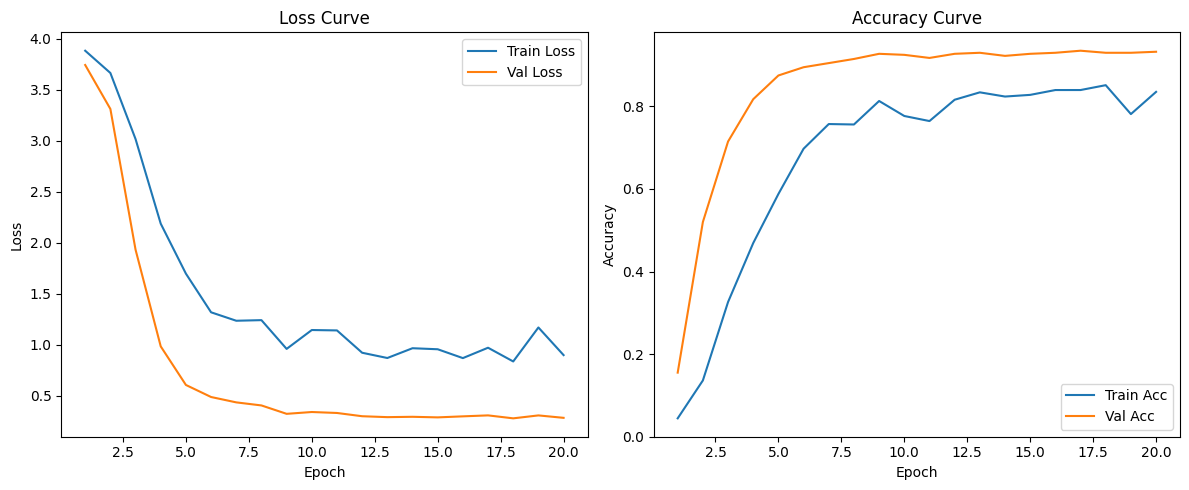

In [26]:
plot_learning_curves(train_losses=train_losses, train_accs=train_accs, val_losses=val_losses, val_accs=val_accs)

In [12]:
model_trainer.model.load_state_dict(torch.load("logmel_cnn14.pth"))

<All keys matched successfully>

In [13]:
model_trainer.test()

Test Loss: 0.3285, Test Acc: 0.9175


(0.32851228475570676, 0.9175)

In [14]:
test_loader_noisy = DataLoader(test_data_noisy, **test_loader_kwargs)

In [15]:
model_trainer.test(test_loader_noisy)

Test Loss: 1.5115, Test Acc: 0.6075


(1.5115180492401123, 0.6075)

In [17]:
model = model_trainer.model
model

TransferCnn14(
  (base): Cnn14(
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block3): ConvBlock(
      (conv1): Conv2d(128, 

___

In [19]:
test_data_predict = ESC50dataset(root_dir=root_dir, sr=sr, folds=test_folds, normalize="peak")
test_loader_predict = DataLoader(test_data_predict, batch_size=1, shuffle=False)

In [20]:
test_data_noisy_predict = ESC50contaminated(root_dir=root_dir, sr=sr, folds=test_folds, normalize="peak", path_to_contaminating_audio="samples/sea_waves.wav")
test_loader_noisy_predict = DataLoader(test_data_noisy_predict, batch_size=1, shuffle=False)

In [21]:
predict_saliency = Predict(model, feature_extractor_predict, interp_method_cls=SaliencyInterpreter, interp_method_kwargs={}, device=device)
predict_gradcam = Predict(model, feature_extractor_predict, interp_method_cls=GradCAMInterpreter, interp_method_kwargs={"target_layers": [model.base.conv_block6.conv2]}, device=device)

In [22]:
results_saliency = predict_saliency.predict_set(test_loader_predict, 'saliency_clean.csv')

Results saved as results/saliency_clean.csv


In [23]:
results_saliency

,FF,AI,AD,AG,FidIn,SPS,COMP
0,0.807760,0.0,98.176369,0.0,0.0,0.767475,9.172155
1,0.005461,0.0,22.821560,0.0,0.0,0.887693,8.472346
2,0.455500,0.0,88.769051,0.0,0.0,0.865012,8.645321
3,0.449588,0.0,93.007477,0.0,0.0,0.917708,8.103765
4,0.747692,0.0,96.724388,0.0,0.0,0.778283,9.126101
...,...,...,...,...,...,...,...
395,0.474184,0.0,97.619194,0.0,0.0,0.764461,9.184182
396,0.852557,0.0,98.347977,0.0,0.0,0.755912,9.228346
397,0.661285,0.0,90.125969,0.0,0.0,0.781461,9.124360
398,0.958125,0.0,99.281212,0.0,0.0,0.760113,9.208173


In [35]:
results_saliency.describe().T[["mean", "std"]]

,mean,std
FF,0.679097,0.247218
AI,0.000000,0.000000
AD,93.147911,11.334028
AG,0.000000,0.000000
FidIn,0.105000,0.306937
SPS,0.783191,0.040571
COMP,9.078915,0.260822


In [40]:
results_gradcam = predict_gradcam.predict_set(test_loader_predict, results_csv_name='gradcam_clean.csv')

Results saved as results/gradcam_clean.csv


In [41]:
results_gradcam

,FF,AI,AD,AG,FidIn,SPS,COMP
0,0.589368,0.0,96.262665,0.0,0.0,0.490846,9.969327
1,0.000003,0.0,70.103493,0.0,0.0,0.000000,0.000000
2,0.150639,0.0,89.506302,0.0,0.0,0.388541,10.119320
3,-0.000006,0.0,95.054153,0.0,0.0,0.934570,7.924671
4,0.526490,0.0,97.205322,0.0,0.0,0.496131,9.925839
...,...,...,...,...,...,...,...
395,0.216719,0.0,13.126050,0.0,1.0,0.297946,10.182989
396,0.030162,0.0,2.213046,0.0,1.0,0.511971,9.869414
397,0.354432,0.0,89.004913,0.0,0.0,0.634608,9.627026
398,0.014078,0.0,82.405975,0.0,1.0,0.547809,9.844276


In [42]:
results_gradcam.describe().T[["mean", "std"]]

,mean,std
FF,0.166925,0.235898
AI,1.250000,11.124157
AD,69.282387,32.452545
AG,0.574071,6.282491
FidIn,0.460000,0.499022
SPS,0.556569,0.244833
COMP,9.018057,2.236557


In [37]:
results_saliency_noisy = predict_saliency.predict_set(test_loader_noisy_predict, 'saliency_seawaves_noise.csv')

Results saved as results/saliency_seawaves_noise.csv


In [38]:
results_saliency_noisy

,FF,AI,AD,AG,FidIn,SPS,COMP
0,0.677376,0.0,98.455986,0.0,0.0,0.756289,9.221260
1,0.186556,0.0,96.291763,0.0,0.0,0.840325,8.777564
2,0.292564,0.0,73.714478,0.0,0.0,0.770208,9.153724
3,0.459484,0.0,62.574375,0.0,1.0,0.755196,9.230047
4,0.350592,0.0,97.397995,0.0,0.0,0.774659,9.145867
...,...,...,...,...,...,...,...
395,0.886273,0.0,96.484871,0.0,0.0,0.755825,9.228083
396,0.936500,0.0,98.246857,0.0,0.0,0.750367,9.249687
397,0.197363,0.0,52.501083,0.0,1.0,0.747313,9.257753
398,0.818142,0.0,98.527489,0.0,0.0,0.789882,9.061106


In [39]:
results_saliency_noisy.describe().T[["mean", "std"]]

,mean,std
FF,0.594035,0.242298
AI,1.000000,9.962336
AD,82.418381,20.119408
AG,0.055945,0.782229
FidIn,0.302500,0.459916
SPS,0.764249,0.014918
COMP,9.187343,0.071187


In [43]:
results_gradcam_noisy = predict_gradcam.predict_set(test_loader_noisy_predict, results_csv_name='gradcam_seawaves_noise.csv')

Results saved as results/gradcam_seawaves_noise.csv


In [44]:
results_gradcam_noisy

,FF,AI,AD,AG,FidIn,SPS,COMP
0,0.476337,0.0,97.802315,0.0,0.0,0.647940,9.563750
1,-0.000040,0.0,91.222382,0.0,0.0,0.000000,0.000000
2,-0.023436,0.0,83.155807,0.0,0.0,0.321874,10.106059
3,0.393027,0.0,58.660583,0.0,1.0,0.277605,10.195515
4,0.260707,0.0,97.560791,0.0,0.0,0.585009,9.762238
...,...,...,...,...,...,...,...
395,0.130961,0.0,37.786354,0.0,1.0,0.333426,10.142489
396,0.039692,0.0,4.649539,0.0,1.0,0.489520,9.905863
397,0.090418,0.0,70.237801,0.0,0.0,0.744933,9.272016
398,-0.049929,0.0,92.501846,0.0,0.0,0.624872,9.671482


In [45]:
results_gradcam_noisy.describe().T[["mean", "std"]]

,mean,std
FF,0.165331,0.232419
AI,3.250000,17.754593
AD,69.801628,30.416620
AG,0.626070,4.165147
FidIn,0.377500,0.485369
SPS,0.495021,0.224219
COMP,9.250613,2.185575


In [46]:
wav, SR = torchaudio.load("samples/crow.wav")
wav = torchaudio.functional.resample(wav, SR, sr)
wav /= wav.abs().max()

wav2, SR = torchaudio.load("samples/sea_waves.wav")
wav2 = torchaudio.functional.resample(wav2, SR, sr)
wav2 /= wav2.abs().max()

In [47]:
wavv = 0.8 * wav + 0.2 * wav2
wavv /= wavv.abs().max()